In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import os
from os import listdir
from os.path import join
from PIL import Image, ImageOps
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import multiprocessing
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import torch.utils.data as data

In [2]:
# connect to google drive in order to get access to the data, model
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
class ImageDataset(Dataset):

     def __init__(self, root_path, input_height=64, input_width=64, transform=None, debug=False, our_dataset=False):
        self.image_list = []
        self.our_dataset=our_dataset


        if debug: # we want to debug the validation set with only 3 classes in A
          classes_of_relevance = {'a','b','c'}
          current_top_dir = root_path
          sub_dirs = os.listdir(root_path)  # a, b, c, ..., o
          for j in range(len(sub_dirs)):
            current_sub_dir = join(current_top_dir, sub_dirs[j])
            if sub_dirs[j] in classes_of_relevance:
              # Add image paths to the image list if the class is of relevance
              self.image_list.extend([join(current_sub_dir, f) for f in os.listdir(current_sub_dir) if f.startswith('color') and f.endswith('png')])
          self.transform=transform
          self.num_of_classes=3
        elif(our_dataset):
          top_dirs = os.listdir(root_path)
          for i in range(len(top_dirs)):
            current_top_dir = join(root_path, top_dirs[i])
            # Add image paths to the image list
            self.image_list.extend([join(current_top_dir, f) for f in os.listdir(current_top_dir) if f.endswith('jpeg')])
          self.transform=transform
          self.num_of_classes=24

        else:
          top_dirs = os.listdir(root_path)  # A, B , C
          for i in range(len(top_dirs)):
            current_top_dir = join(root_path, top_dirs[i])
            sub_dirs = os.listdir(current_top_dir)  # a, b, c, ..., o
            for j in range(len(sub_dirs)):
              current_sub_dir = join(current_top_dir, sub_dirs[j])
              # Add image paths to the image list
              self.image_list.extend([join(current_sub_dir, f) for f in os.listdir(current_sub_dir) if f.startswith('color') and f.endswith('png')])
          self.image_list = sorted(self.image_list)
          self.transform=transform
          self.num_of_classes=24



     def __len__(self):
      return len(self.image_list)

     def __getitem__(self, index):
      # Get the image path at the given index
      img_path = self.image_list[index]
      img = Image.open(img_path) # Open the image using PIL
      if self.transform:
        img = self.transform(img)
      if (self.our_dataset):
        return img
      else:
        label=self.extract_label(self.image_list[index])
        return (img,label)

     def extract_label(self, filename):
          # Extract the label from the filename
         label = int(os.path.basename(filename).split('_')[1])
         if label > 8:
          label -=1

         return torch.tensor(int(label))


In [4]:
# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # according to the VGG19 that is trained on the data of imagenet
])


In [5]:
DEBUG = False

In [6]:
dataset = ImageDataset('/content/drive/MyDrive/dataset_dp_project_new/dataset5', transform=data_transform, debug=DEBUG)
print(len(dataset))

61543


In [7]:
from torch.utils.data import random_split

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(5))

# Further split theg training dataset into training and validation sets
val_size = int(0.25 * len(train_dataset))  # 25% of the training set for validation
train_size = len(train_dataset) - val_size  # Remaining 60% for training

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(6))

In [8]:
# img_height = 224
# img_width = 224
#img_channels = 3
if DEBUG:
  num_classes=3
else:
  num_classes=24
# weights = '/content/vgg19.pth' # the weights that we use for the vgg19 pretrained model

def build_model():
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False # we are freezing the weights of this model in order to create feature extractor

    num_features = model.classifier[6].in_features # we only replace the last layer of the vgg19 and adding instead our layers to train the model
    model.classifier[6] = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.BatchNorm1d(512),
        nn.Linear(512, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.BatchNorm1d(512),
        nn.Linear(512, num_classes),
    )

    return model


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #in order to set our device when working on cpu or gpu
model = build_model()
model.load_state_dict(torch.load("/content/drive/MyDrive/checkpoints/model_batch128_5")["net"])
model = model.to(device) # send the model to the device
from torchsummary import summary
summary(model, input_size=(3, 224, 224))



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 284MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device, num_classes=24):
    model.eval() # put in evaluation mode, turn of DropOut, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # here we get the max score of the suitable label that fit to our images
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item() # testing if the prediction suits the label of the image and if it is count it and add it to the total correct

    model_accuracy = total_correct / total_images * 100
    return model_accuracy


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import time
# Setting the hyper parameters of the model
# Set the number of epochs
start_epoch = 6
end_epochs = 10
batch_size = 16  #we tried many diffrent batch_sizes and took the best of them
learning_rate = 1e-3
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() # for the mission of classification
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[2, 4], gamma=0.1)
counter = 0

# now we use the class that we defined in order to upload the dataset batch by batch
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
epoch_losses_mean = {}
epoch_length = np.arange(1, 10, 1)

train_acc_values = []
val_acc_values = []
for epoch in range(start_epoch, end_epochs + 1):
    model.train() # put in training mode, turn on DropOut, BatchNorm uses batch's statistics
    running_loss = 0.0
    epoch_time = time.time()

    for i, (inputs, labels) in enumerate(train_dataloader):
      # send them to device
      inputs = inputs.to(device)
      labels = labels.to(device)

      # forward + backward + optimize
      outputs = model(inputs) # forward pass
      loss = criterion(outputs, labels) # calculate the loss
      # always the same 3 steps
      optimizer.zero_grad() # zero the parameter gradients
      loss.backward() # backpropagation
      optimizer.step() # update parameters
      running_loss += loss.data.item()
    scheduler.step()
    # Normalizing the loss by the total number of train batches
    epoch_losses_mean[epoch] = running_loss/len(train_dataloader)
    running_loss /= len(train_dataloader)
    # Calculate training/test set accuracy of the existing model
    train_accuracy = calculate_accuracy(model, train_dataloader, device , num_classes)
    val_accuracy = calculate_accuracy(model, val_dataloader, device)
    # Append accuracy values to the lists
    train_acc_values.append(train_accuracy)
    val_acc_values.append(val_accuracy)
    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, val_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)

    print(log)

 # save model
    if epoch % 1 == 0:
        print('==> Saving model ...')
        state = {
            'net': model.state_dict(),
            'epoch': epoch,
         }
        if not os.path.isdir('./checkpoints'):
            os.mkdir('./checkpoints')
        torch.save(state, f'./checkpoints/model_batch16_{epoch}')
print('==> Finished Training ...')





In [2]:
# # the results of the loss function on the train set and the accuracy on the train and val set
df = pd.read_csv("/content/drive/MyDrive/run_data_model_batch128.csv")
epoch_losses_mean = df["epoch_losses_mean"].tolist()
train_acc_values = df["train_acc_values"].tolist()
val_acc_values = df["val_acc_values"].tolist()
epoch_length = np.arange(1,len(epoch_losses_mean),1)

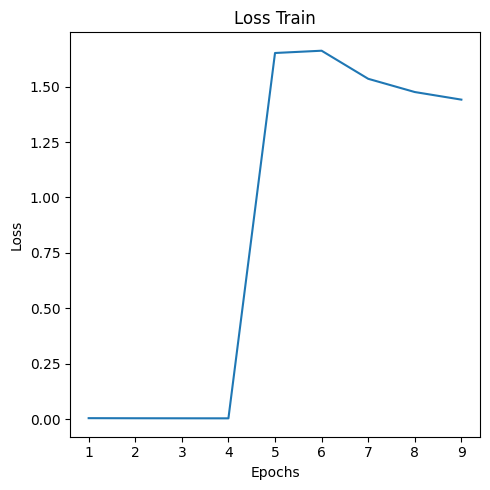

In [13]:
# plot the train loss
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(epoch_length, [epoch_losses_mean[i] for i in epoch_length])
ax.set_title('Loss Train')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.tight_layout()


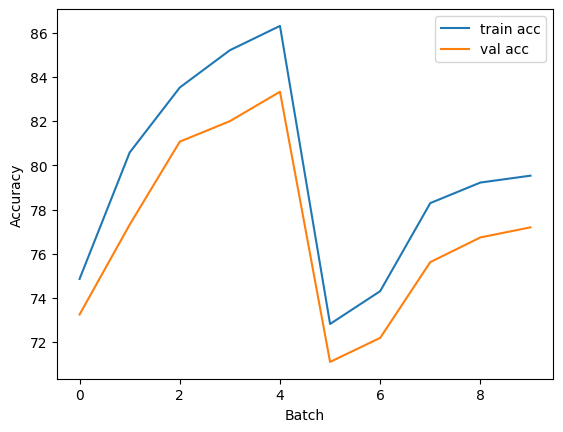

In [14]:

# Plot the training and validation accuracy
plt.plot(train_acc_values, label='train acc')
plt.plot(val_acc_values, label='val acc')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We tried to keep training our model after 5 epochs from the point that we stopped but we didn't reach a better accuracy on the test set
